# Calibrate with pyFAI
---

### Jupyter setup
! *Do not edit it if you are not sure in what yoou are doing* !

In [6]:
%matplotlib nbagg
# The notebook interface (nbagg) is needed in jupyter-notebook while the widget is recommended for jupyer lab
# %matplotlib widget

import pyFAI
import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
from pyFAI.goniometer import SingleGeometry
# print(f"PyFAI version {pyFAI.version}")

from IPython.display import HTML
from IPython.display import display

show_hide = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="show / hide code"></form>''')
display(show_hide)

In [22]:
!ls
# cd or ls to go to the directory with files

'Analysis of 2D integration.ipynb'   PZT5_5.ipynb
'Average files with pyFAI.ipynb'     test2.edf
 calibration_tmpl.ipynb		     thinclient_drives
 env_requirements.txt		    'Time series by PCA - 1D pattern.ipynb'
 exp_process			    'Time series by PCA - Frames.ipynb'
 github_token.txt		     Untitled2.ipynb
 hc4682				     Untitled.ipynb
 nanocal


<IPython.core.display.Javascript object>


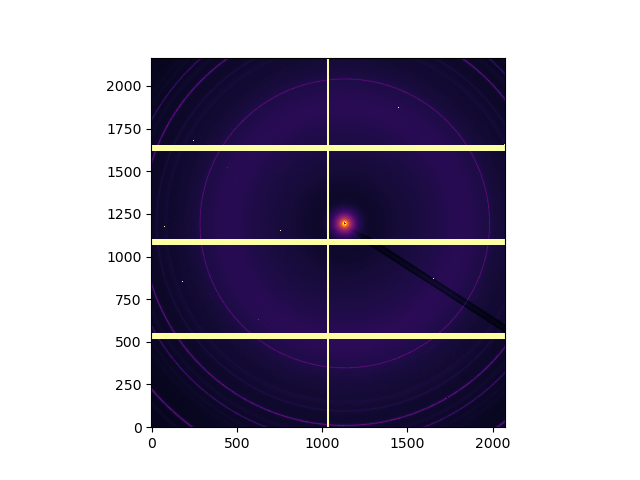

In [25]:
img = fabio.open("test2.edf").data
jupyter.display(img);

In [44]:
# Some parameters like the wavelength, the calibrant and the diffraction image:
energy = 13 #kEv
wavelength = (12.3984/energy)/(10**10) #A
detector = pyFAI.detector_factory("Eiger4m")
calibrant = pyFAI.calibrant.CALIBRANT_FACTORY("alpha_Al2O3")
# Calibrants available: Si_SRM640e, CuO, Si_SRM640a, alpha_Al2O3, C14H30O, CeO2, 
# Ni, Si_SRM640c, Si, LaB6, ZnO, TiO2, cristobaltite, NaCl, PBBA, Si_SRM640b, Cr2O3, 
# Al, mock, LaB6_SRM660a, LaB6_SRM660b, LaB6_SRM660c, Au, AgBh, Si_SRM640, Si_SRM640d, 
# quartz, Pt, CrOx, hydrocerussite
calibrant.wavelength = wavelength

# This allow to measure approximatively the position of the beam center ...
x = 1132 # x-coordinate of the beam-center in pixels
y = 1192 # y-coordinate of the beam-center in pixels
d = 225 # This is the distance in mm (unit used by Fit2d)
wl = wavelength # The wavelength is 1 Å

In [45]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=detector, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
Wavelength= 9.537231e-11m
SampleDetDist= 2.250000e-01m	PONI= 8.940000e-02, 8.490000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 225.000mm	Center: x=1132.000, y=1192.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [46]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", img, calibrant=calibrant, detector=detector, geometry=initial)
sg.extract_cp(max_rings=3)

ControlPoints instance containing 3 group of point:
alpha_Al2O3 Calibrant with 31 reflections at wavelength 9.53723076923077e-11
Containing 3 groups of points:
# j ring 0: 347 points
# k ring 1: 181 points
# l ring 2: 16 points

<IPython.core.display.Javascript object>


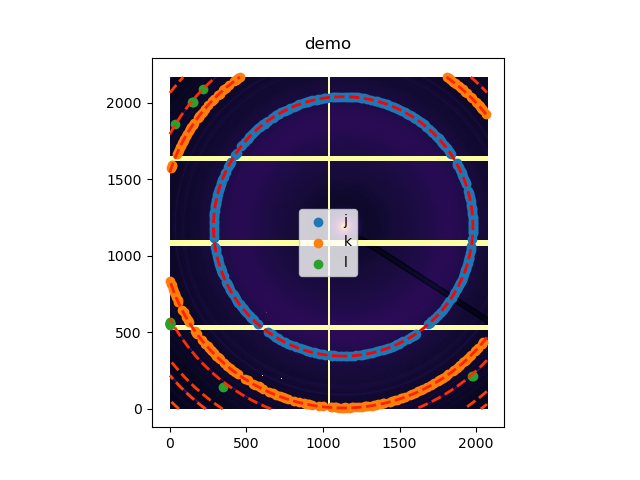

In [47]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
jupyter.display(sg=sg);

In [56]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
Wavelength= 9.537231e-11m
SampleDetDist= 2.249645e-01m	PONI= 8.944105e-02, 8.496237e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 224.965mm	Center: x=1132.832, y=1192.547 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

<IPython.core.display.Javascript object>


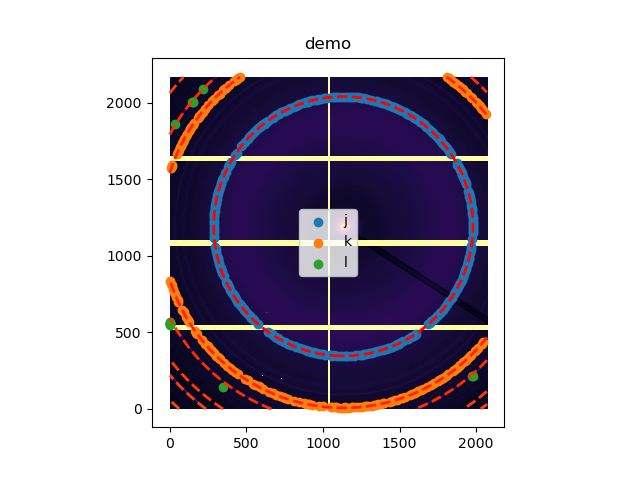

In [57]:
jupyter.display(sg=sg);

<IPython.core.display.Javascript object>


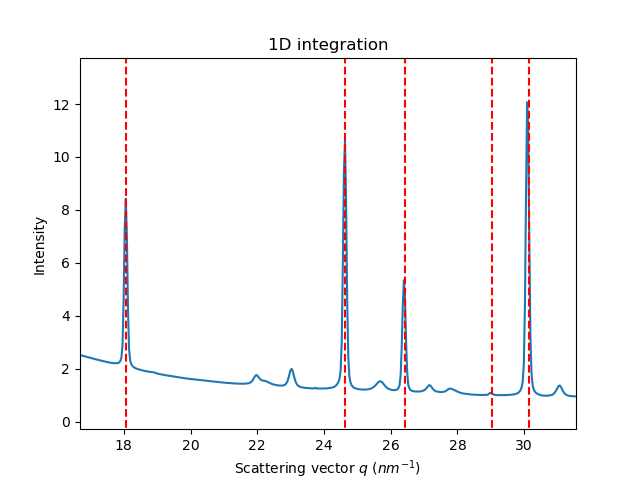

In [64]:
#Save the geometry obtained
sg.geometry_refinement.save("geometry.poni")
#Use the geometry to perform an azimuthal integration and check it
mask = img > 50000
ai = sg.get_ai()
# Units can be "q_nm^-1" (default), "2th_deg", "r_mm" for now.
res = ai.integrate1d(img, 1000, mask=mask, unit="q_nm^-1")
ax = jupyter.plot1d(res,calibrant=calibrant)